In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded wind data
file_path = "./Data/Power_Output_2019_2023.csv"
df = pd.read_csv(file_path)
df

,Date/Time (LST),Wind Spd (km/h),Power Output (kW)
0,2019-01-01 00:00,3.0,0.000000
1,2019-01-01 01:00,12.0,558.958703
2,2019-01-01 02:00,29.0,669.768076
3,2019-01-01 03:00,20.0,722.197385
4,2019-01-01 04:00,13.0,647.867161
...,...,...,...
87643,NaN,6.0,76.428672
87644,NaN,5.0,42.014492
87645,NaN,6.0,76.428672
87646,NaN,8.0,195.177573


In [153]:
# Convert timestamp to datetime
df['Date/Time (LST)'] = pd.to_datetime(df['Date/Time (LST)'])

# Check for negative values in 'Power Output (kW)' to zero
df['Power Output (kW)'] = df['Power Output (kW)'].clip(lower=0)

# interpulate missing values
df['Power Output (kW)'] = df['Power Output (kW)'].interpolate(method='linear')

# Add a date column for grouping
df['date'] = df['Date/Time (LST)'].dt.date

# Group by date
grouped = df.groupby('date')

# Keep only full days (24 intervals of 1 hour = 24 hours)
full_days = [day for day, group in grouped if len(group) == 24]

# Create a list to store daily 3-stage trajectories
scenario = []

for day in full_days:
    group = grouped.get_group(day).reset_index(drop=True)
    # stage1 = group.loc[0:5, 'Power Output (kW)'].values  # 00:00 to 06:00
    stage1 = group.loc[6:11, 'Power Output (kW)'].values  # 06:00 to 12:00
    stage2 = group.loc[12:17, 'Power Output (kW)'].values  # 12:00 to 18:00
    stage3 = group.loc[18:23, 'Power Output (kW)'].values  # 18:00 to 24:00
    scenario.append((stage1, stage2, stage3))


In [182]:
len(full_days)

1826

In [176]:
scenarios_list = [np.concatenate((s[0], s[1], s[2]), axis=0) for s in scenario]
scenarios_list[0:6]

[array([195.17757312, 277.71251932, 277.71251932, 369.14770864,
        647.86716148, 369.14770864, 558.95870323, 747.04992071,
        647.86716148, 369.14770864, 277.71251932,  42.01449246,
         42.01449246,  42.01449246,   0.        ,   0.        ,
          0.        ,  12.87399781]),
 array([  0.        ,   0.        ,   0.        ,  12.87399781,
          0.        ,  42.01449246,   0.        ,   0.        ,
          0.        , 195.17757312,  12.87399781,   0.        ,
         12.87399781,  12.87399781,  12.87399781,   0.        ,
          0.        ,   0.        ]),
 array([647.86716148, 747.04992071, 647.86716148, 749.30448223,
        647.86716148, 369.14770864, 715.97583251, 747.04992071,
        277.71251932, 369.14770864, 462.47950916,  76.42867179,
        647.86716148, 462.47950916, 647.86716148, 277.71251932,
        369.14770864, 558.95870323]),
 array([120.73907545, 277.71251932, 195.17757312, 195.17757312,
        558.95870323, 558.95870323, 558.95870323, 558.

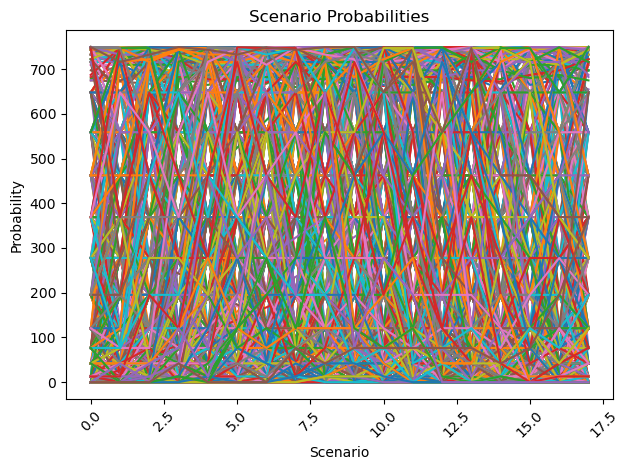

In [181]:
# Plot the probabilities of each scenario
scenarios_list = [np.concatenate((s[0], s[1], s[2]), axis=0) for s in scenario]
for s in scenarios_list:
    plt.plot(range(18), s)
plt.xlabel('Scenario')
plt.ylabel('Probability')
plt.title('Scenario Probabilities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [147]:
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict

# Number of clusters per stage
n_clusters_stage1 = 2
n_clusters_stage2 = 2
n_clusters_stage3 = 2

# Separate all stage vectors
stage1_vectors = np.array([s[0] for s in scenario])

# Step 1: Cluster stage 1
kmeans_stage1 = KMeans(n_clusters=n_clusters_stage1, random_state=42)
labels_stage1 = kmeans_stage1.fit_predict(stage1_vectors)

# Map from stage 1 cluster to indices of samples
stage2_inputs = defaultdict(list)
for i, label1 in enumerate(labels_stage1):
    stage2_inputs[label1].append(i)

# Stage 2 clustering (nested per stage 1 cluster)
stage2_results = {}
for label1, indices in stage2_inputs.items():
    vectors = np.array([scenario[i][1] for i in indices])
    if len(vectors) < n_clusters_stage2:
        continue  # Skip if not enough samples
    kmeans_stage2 = KMeans(n_clusters=n_clusters_stage2, random_state=42)
    labels_stage2 = kmeans_stage2.fit_predict(vectors)
    stage2_results[label1] = (kmeans_stage2, labels_stage2, indices)

# Stage 3 clustering (nested per stage 2 cluster)
scenario_tree = []
scenario_id = 1
stage3_results = {}
for label1, (kmeans2, labels2, indices2) in stage2_results.items():
    for label2 in range(n_clusters_stage2):
        sub_indices = [indices2[i] for i, lbl in enumerate(labels2) if lbl == label2]
        vectors = np.array([scenario[i][2] for i in sub_indices])
        if len(vectors) < n_clusters_stage3:
            continue
        kmeans_stage3 = KMeans(n_clusters=n_clusters_stage3, random_state=42)
        labels_stage3 = kmeans_stage3.fit_predict(vectors)
        for label3 in range(n_clusters_stage3):
            count = sum(1 for l in labels_stage3 if l == label3)
            probability = count / len(sub_indices)
            scenario_tree.append({
                "scenario": f"s{scenario_id}",
                "stage1_node": label1,
                "stage2_node": label2,
                "stage3_node": label3,
                "probability": round(probability, 4)
            })
            stage3_results[scenario_id] = (kmeans_stage3, labels_stage3, sub_indices)

            scenario_id += 1

import pandas as pd
scenario_df = pd.DataFrame(scenario_tree)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Scenario Tree Structure", dataframe=scenario_df)

/var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/ipykernel_10155/2257656301.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


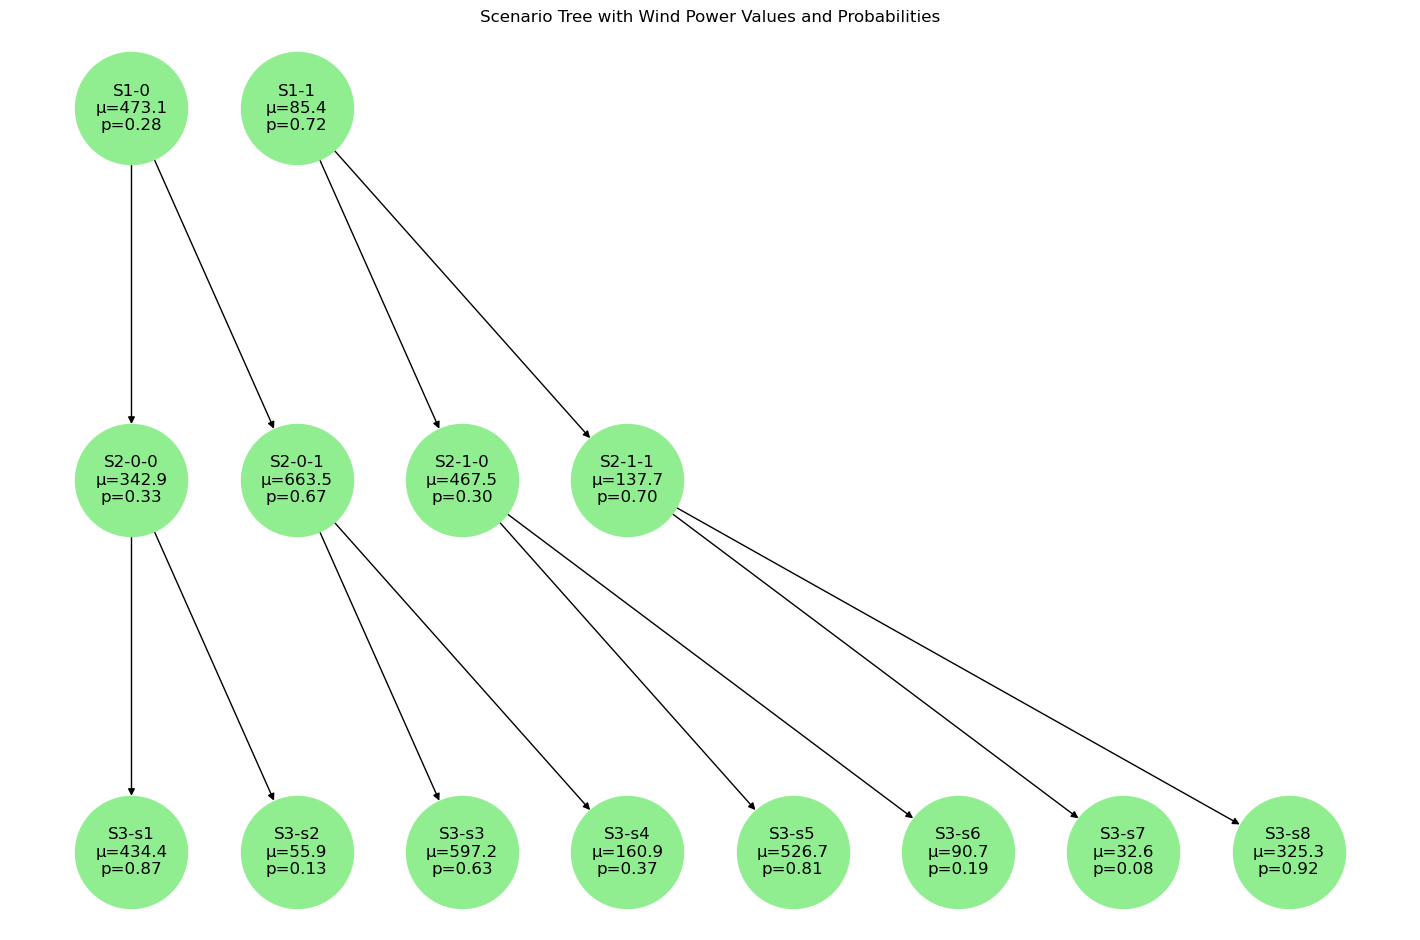

In [148]:
# === Build tree nodes with centroid values and probabilities ===
G = nx.DiGraph()
node_levels = {}
node_labels = {}

# Stage 1 nodes
stage1_probs = np.bincount(labels_stage1) / len(labels_stage1)
for i, prob in enumerate(stage1_probs):
    label = f"S1-{i}\nμ={kmeans_stage1.cluster_centers_[i].mean():.1f}\np={prob:.2f}"
    node = f"S1-{i}"
    node_levels[node] = 0
    node_labels[node] = label

# Stage 2 nodes
for l1, (kmeans2, labels2, indices1) in stage2_results.items():
    prob_l1 = stage1_probs[l1]
    stage2_probs = np.bincount(labels2) / len(labels2)
    for l2 in range(len(stage2_probs)):
        label = f"S2-{l1}-{l2}\nμ={kmeans2.cluster_centers_[l2].mean():.1f}\np={stage2_probs[l2]:.2f}"
        node = f"S2-{l1}-{l2}"
        parent = f"S1-{l1}"
        G.add_edge(parent, node)
        node_levels[node] = 1
        node_labels[node] = label

# Stage 3 nodes
for i, (row, (label1, (kmeans3, labels3, indices3))) in enumerate(zip(scenario_tree, stage3_results.items())):
    s_id = row["scenario"]
    s1 = f"S1-{row['stage1_node']}"
    s2 = f"S2-{row['stage1_node']}-{row['stage2_node']}"
    s3 = f"S3-{s_id}"
    prob = row["probability"]
    if (i+1)%2 == 0:
        label = f"S3-{s_id}\nμ={kmeans3.cluster_centers_[0].mean():.1f}\np={prob:.2f}"
    else:
        label = f"S3-{s_id}\nμ={kmeans3.cluster_centers_[1].mean():.1f}\np={prob:.2f}"
    G.add_edge(s2, s3)
    node_levels[s3] = 2
    node_labels[s3] = label

# === Layout manually based on levels ===
pos = {}
layer_nodes = defaultdict(list)
for node, layer in node_levels.items():
    layer_nodes[layer].append(node)

for layer, nodes in layer_nodes.items():
    for i, node in enumerate(sorted(nodes)):
        pos[node] = (i, -layer)

# === Plotting ===
plt.figure(figsize=(14, 9))
nx.draw(G, pos, labels=node_labels, node_size=6500, node_color="lightgreen", font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title("Scenario Tree with Wind Power Values and Probabilities")
plt.axis("off")
plt.tight_layout()
plt.show()

In [146]:
len(stage3_results)

4